Checking the recombination rate along the chromosome compared to North/South Ancestry, as calculated in the Baboon diversity paper.

In [1]:
%run ../scripts/notebook_settings_lean.py
from horizonplot import horizonplot

In [2]:
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster_females.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")
mapping = {}
for i, row in meta_data_samples.iterrows():
    if row.PGDP_ID[0] != "P":
        mapping["Sci_"+row.PGDP_ID] = row.Origin
    else:
        mapping[row.PGDP_ID] = row.Origin

In [3]:
df_l = []
baboon_path = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis"
for population in ['anubis_tanzania']:
    for chrom in ["8", "X"]:
        for ind in idfile.loc[(idfile["pop"] == population) & (idfile.inclusion == 1)].PGDP_ID:
            name = population+"_chr"+chrom+"_8_cluster_"+ind+".txt"
            ind_df = pd.read_csv(baboon_path+"/steps/paint_summary/"+name, sep=" ")
            ind_df["PGDP_ID"] = ind
            ind_df["chrom"] = chrom
            df_l.append(ind_df)
a_8_df = pd.concat(df_l)
a_8_df["north"] = a_8_df.anubis_ethiopia+a_8_df.hamadryas+a_8_df.papio
a_8_df["norm_north"] = (a_8_df.north-a_8_df.iloc[:,1:8].sum(axis=1)/2)
a_8_df["percent_north"] = (a_8_df.north/a_8_df.iloc[:,1:8].sum(axis=1))
a_8_df["pop"] = a_8_df["PGDP_ID"].map(mapping)
a_8_df["start"] = a_8_df["windows"]

In [4]:
input_df = a_8_df
recomb_map_path = "/home/eriks/baboondiversity/data/PG_panu3_recombination_map/ldhat_conversion_chr{}_updated.txt"
window_size = 100000
df_l = []
for chrom in ["8", "X"]:
    windows_length = {}
    input_temp = input_df.loc[input_df.chrom == chrom]
    recomb_map = pd.read_csv(recomb_map_path.format(chrom), sep=" ")
    windows = sorted(input_temp["windows"].unique())
    for window in windows[:-1]:
        windows_length[window] =(recomb_map.loc[recomb_map.position >= window+window_size]["Genetic_Map(cM)"].iloc[0]-
                                 recomb_map.loc[recomb_map.position >= window]["Genetic_Map(cM)"].iloc[0])
    windows_length[windows[-1]] = (recomb_map["Genetic_Map(cM)"].iloc[-2] - 
                            recomb_map.loc[recomb_map.position >= window]["Genetic_Map(cM)"].iloc[0])
    input_temp["cM"] = input_temp["windows"].map(windows_length)
    df_l.append(input_temp)
recomb_df = pd.concat(df_l)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


[None]

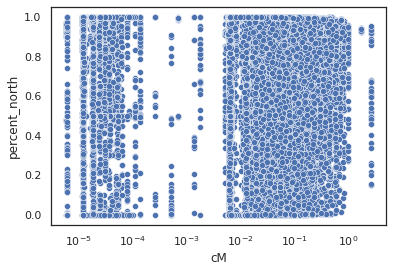

In [5]:
g = sns.scatterplot(data=recomb_df.loc[recomb_df.chrom == "X"], x="cM", y="percent_north")
g.set(xscale="log")

[None, Text(0.5, 1.0, 'Recombination dist')]

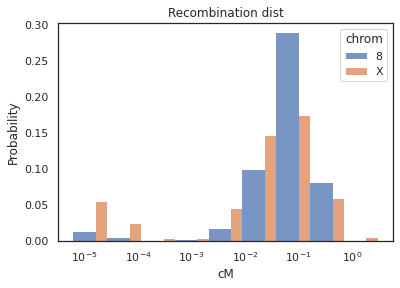

In [6]:
g = sns.histplot(recomb_df, x="cM", hue="chrom", stat="probability",
            bins=np.logspace(np.log10(recomb_df["cM"].min()),np.log10(3), 10), multiple="dodge")
g.set(xscale="log", title="Recombination dist")

Constructing the interval index and checking chrX

In [7]:
df = recomb_df.loc[recomb_df.chrom == "X"]
bins = 5
tuple_l = []
for b in range(1, bins+1):
    lower = (b-1)/bins
    upper = b/bins
    tuple_l.append((df["cM"].quantile(lower), df["cM"].quantile(upper)))
intervals = pd.IntervalIndex.from_tuples(tuple_l)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


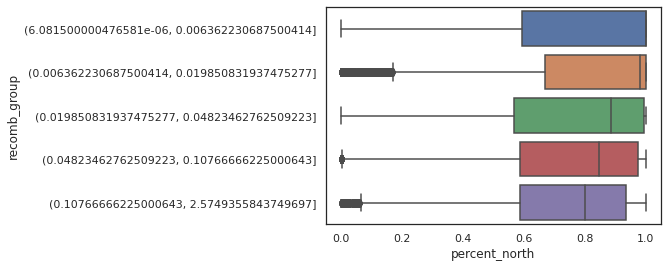

In [8]:
df["recomb_group"] = pd.cut(df["cM"], bins=intervals)
g = sns.boxplot(data=df, x="percent_north", y="recomb_group")

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


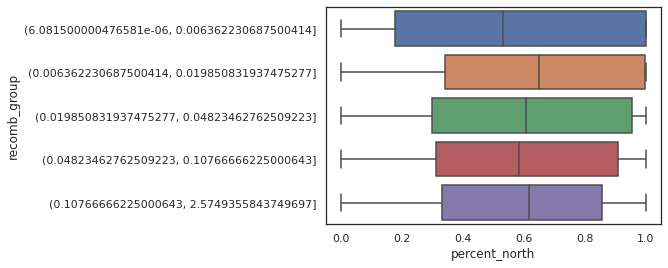

In [9]:
df_t = df.loc[df["pop"] == "Tarangire, Tanzania"]
df_t["recomb_group"] = pd.cut(df_t["cM"], bins=intervals)
g = sns.boxplot(data=df_t, x="percent_north", y="recomb_group")

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


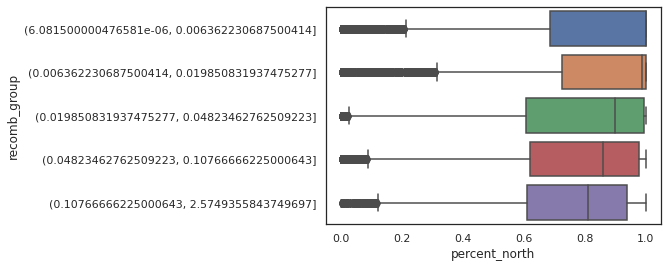

In [10]:
df_o = df.loc[df["pop"] != "Tarangire, Tanzania"]
df_o["recomb_group"] = pd.cut(df_o["cM"], bins=intervals)
g = sns.boxplot(data=df_o, x="percent_north", y="recomb_group")

Checking chr8

In [11]:
df = recomb_df.loc[recomb_df.chrom == "8"]
bins = 5
tuple_l = []
for b in range(1, bins+1):
    lower = (b-1)/bins
    upper = b/bins
    tuple_l.append((df["cM"].quantile(lower), df["cM"].quantile(upper)))
intervals = pd.IntervalIndex.from_tuples(tuple_l)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


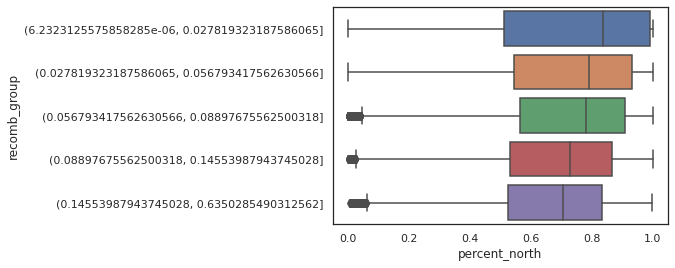

In [12]:
df["recomb_group"] = pd.cut(df["cM"], bins=intervals)
g = sns.boxplot(data=df, x="percent_north", y="recomb_group")

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


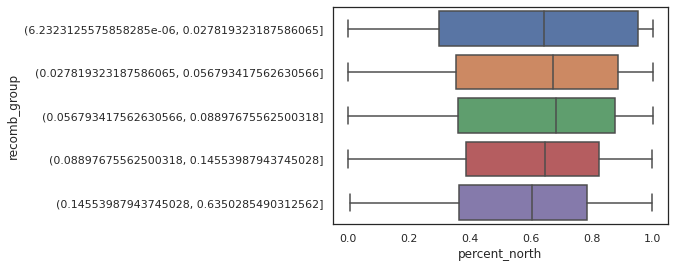

In [13]:
df_t = df.loc[df["pop"] == "Tarangire, Tanzania"]
df_t["recomb_group"] = pd.cut(df_t["cM"], bins=intervals)
g = sns.boxplot(data=df_t, x="percent_north", y="recomb_group")

Checking with the 7 population grouping to remove backcrossing effects

In [14]:
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_7_cluster_females.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")
mapping = {}
for i, row in meta_data_samples.iterrows():
    if row.PGDP_ID[0] != "P":
        mapping["Sci_"+row.PGDP_ID] = row.Origin
    else:
        mapping[row.PGDP_ID] = row.Origin

In [15]:
df_l = []
baboon_path = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis"
for population in ['cyno_anubis_t']:
    for chrom in ["8", "X"]:
        for ind in idfile.loc[(idfile["pop"] == population) & (idfile.inclusion == 1)].PGDP_ID:
            name = population+"_chr"+chrom+"_7_cluster_"+ind+".txt"
            ind_df = pd.read_csv(baboon_path+"/steps/paint_summary/"+name, sep=" ")
            ind_df["PGDP_ID"] = ind
            ind_df["chrom"] = chrom
            df_l.append(ind_df)
a_7_df = pd.concat(df_l)
a_7_df["north"] = a_7_df.anubis_ethiopia+a_7_df.hamadryas+a_7_df.papio
a_7_df["norm_north"] = (a_7_df.north-a_7_df.iloc[:,1:8].sum(axis=1)/2)
a_7_df["percent_north"] = (a_7_df.north/a_7_df.iloc[:,1:8].sum(axis=1))
a_7_df["pop"] = a_7_df["PGDP_ID"].map(mapping)
a_7_df["start"] = a_7_df["windows"]

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  del sys.path[0]
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


In [16]:
input_df = a_7_df
recomb_map_path = "/home/eriks/baboondiversity/data/PG_panu3_recombination_map/ldhat_conversion_chr{}_updated.txt"
window_size = 100000
df_l = []
for chrom in ["8", "X"]:
    windows_length = {}
    input_temp = input_df.loc[input_df.chrom == chrom]
    recomb_map = pd.read_csv(recomb_map_path.format(chrom), sep=" ")
    windows = sorted(input_temp["windows"].unique())
    for window in windows[:-1]:
        windows_length[window] =(recomb_map.loc[recomb_map.position >= window+window_size]["Genetic_Map(cM)"].iloc[0]-
                                 recomb_map.loc[recomb_map.position >= window]["Genetic_Map(cM)"].iloc[0])
    windows_length[windows[-1]] = (recomb_map["Genetic_Map(cM)"].iloc[-2] - 
                            recomb_map.loc[recomb_map.position >= window]["Genetic_Map(cM)"].iloc[0])
    input_temp["cM"] = input_temp["windows"].map(windows_length)
    df_l.append(input_temp)
recomb_df = pd.concat(df_l)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [17]:
df_x = recomb_df.loc[recomb_df.chrom == "X"]
bins = 5
tuple_l = []
for b in range(1, bins+1):
    lower = (b-1)/bins
    upper = b/bins
    tuple_l.append((df_x["cM"].quantile(lower), df_x["cM"].quantile(upper)))
intervals = pd.IntervalIndex.from_tuples(tuple_l)

In [18]:
df_x["pop"].unique()

array(['Mikumi, Tanzania', 'Serengeti, Tanzania', 'Arusha, Tanzania',
       'Ngorongoro, Tanzania', 'Ruaha, Tanzania', 'Gombe, Tanzania',
       'Udzungwa, Tanzania', 'Selous, Tanzania', 'Lake Manyara, Tanzania',
       'Tarangire, Tanzania'], dtype=object)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


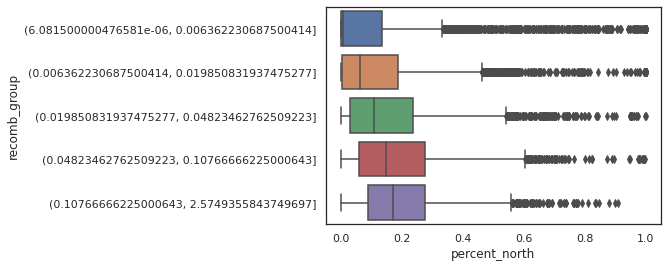

In [19]:
df = df_x.loc[df_x["pop"] == "Mikumi, Tanzania"]
df["recomb_group"] = pd.cut(df["cM"], bins=intervals)
g = sns.boxplot(data=df, x="percent_north", y="recomb_group")

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


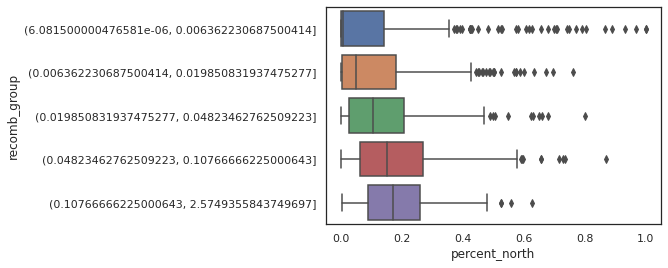

In [20]:
df = df_x.loc[df_x["pop"] == "Selous, Tanzania"]
df["recomb_group"] = pd.cut(df["cM"], bins=intervals)
g = sns.boxplot(data=df, x="percent_north", y="recomb_group")

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


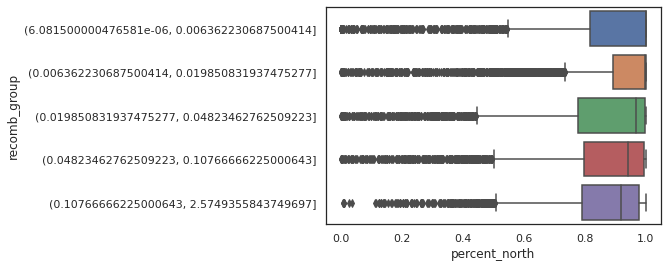

In [21]:
df = df_x.loc[df_x["pop"] == "Lake Manyara, Tanzania"]
df["recomb_group"] = pd.cut(df["cM"], bins=intervals)
g = sns.boxplot(data=df, x="percent_north", y="recomb_group")

In [40]:
df_8 = recomb_df.loc[recomb_df.chrom == "8"]
bins = 10
tuple_l = []
for b in range(1, bins+1):
    lower = (b-1)/bins
    upper = b/bins
    tuple_l.append((df_8["cM"].quantile(lower), df_8["cM"].quantile(upper)))
intervals = pd.IntervalIndex.from_tuples(tuple_l)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


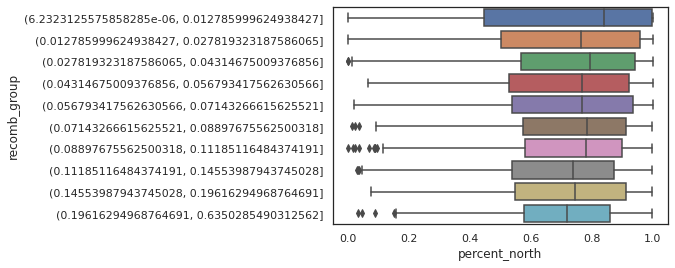

In [41]:
df = df_8.loc[df_8["pop"] == "Tarangire, Tanzania"]
df["recomb_group"] = pd.cut(df["cM"], bins=intervals)
g = sns.boxplot(data=df, x="percent_north", y="recomb_group")

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


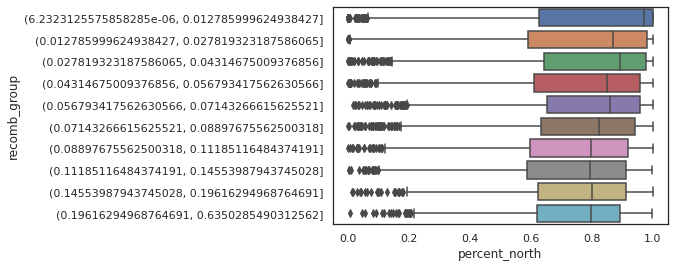

In [42]:
df = df_8.loc[df_8["pop"] == "Gombe, Tanzania"]
df["recomb_group"] = pd.cut(df["cM"], bins=intervals)
g = sns.boxplot(data=df, x="percent_north", y="recomb_group")

In [33]:
df["recomb_group"]

0        (0.08897675562500318, 0.14553987943745028]
1         (0.14553987943745028, 0.6350285490312562]
2         (0.14553987943745028, 0.6350285490312562]
3       (0.056793417562630566, 0.08897675562500318]
4       (0.056793417562630566, 0.08897675562500318]
                           ...                     
1399    (0.056793417562630566, 0.08897675562500318]
1400     (0.08897675562500318, 0.14553987943745028]
1401    (0.056793417562630566, 0.08897675562500318]
1402    (0.056793417562630566, 0.08897675562500318]
1403      (0.14553987943745028, 0.6350285490312562]
Name: recomb_group, Length: 5616, dtype: category
Categories (5, interval[float64, right]): [(6.2323125575858285e-06, 0.027819323187586065] < (0.027819323187586065, 0.056793417562630566] < (0.056793417562630566, 0.08897675562500318] < (0.08897675562500318, 0.14553987943745028] < (0.14553987943745028, 0.6350285490312562]]

Implementing a different plotting method, in which I plot the mean and confidence interval for each bracket.

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


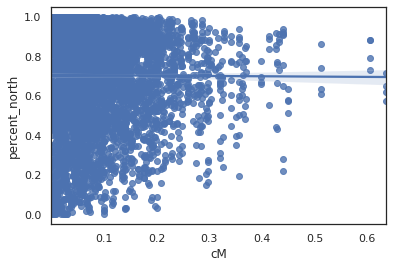

In [27]:
df = df_8.loc[df_8["pop"] == "Tarangire, Tanzania"]
df["recomb_group"] = pd.cut(df["cM"], bins=intervals)
g = sns.regplot(data=df, y="percent_north", x="cM")